# KE5105 - Building Electrical Consumption Forecasting

# Modelling - Base models

## Summary of Findings
* **MRB** building dataset
* Base 4x128 GRU 2x32 Dense
    * Run #1 Min Validation MAE (normalised) = xxx (xxx) @ epoch xxx
    * Run #2 Min Validation MAE (normalised) = xxx (xxx) @ epoch xxx
    * Run #3 Min Validation MAE (normalised) = xxx (xxx) @ epoch xxx
* Base 4x64 GRU 1x32 Dense
    * Run #1 Min Validation MAE (normalised) = xxx (xxx) @ epoch xxx
    * Run #2 Min Validation MAE (normalised) = xxx (xxx) @ epoch xxx
    * Run #3 Min Validation MAE (normalised) = xxx (xxx) @ epoch xxx
* Base 4x32 GRU
    * Run #1 Min Validation MAE (normalised) = xxx (xxx) @ epoch xxx
    * Run #2 Min Validation MAE (normalised) = xxx (xxx) @ epoch xxx
    * Run #3 Min Validation MAE (normalised) = xxx (xxx) @ epoch xxx
* Base 2x32 GRU
    * Run #1 Min Validation MAE (normalised) = xxx (xxx) @ epoch xxx
    * Run #2 Min Validation MAE (normalised) = xxx (xxx) @ epoch xxx
    * Run #3 Min Validation MAE (normalised) = xxx (xxx) @ epoch xxx

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython',
 '/home/tkokkeng/Documents/KE5105/ETL/source']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential, load_model
from keras import layers
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend

Using TensorFlow backend.


## Load data for building MRB

In [4]:
mrb_train = mu.load_data_by_bldg(['MRB'], 'imputed_train')

In [5]:
mrb_train[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31617 entries, 2015-06-12 07:30:00 to 2017-03-31 23:30:00
Data columns (total 10 columns):
PWMMRIC1                     29851 non-null float64
PWMMRIC2                     29851 non-null float64
BTUMochtarRiady              29448 non-null float64
PWMMRIC1_30min_avg           29818 non-null float64
PWMMRIC2_30min_avg           29818 non-null float64
BTUMochtarRiady_30min_avg    29416 non-null float64
PWM_sumadd                   29818 non-null float64
PWM_30min_avg                29861 non-null float64
BTU_sumadd                   29416 non-null float64
BTU_30min_avg                29469 non-null float64
dtypes: float64(10)
memory usage: 2.7 MB


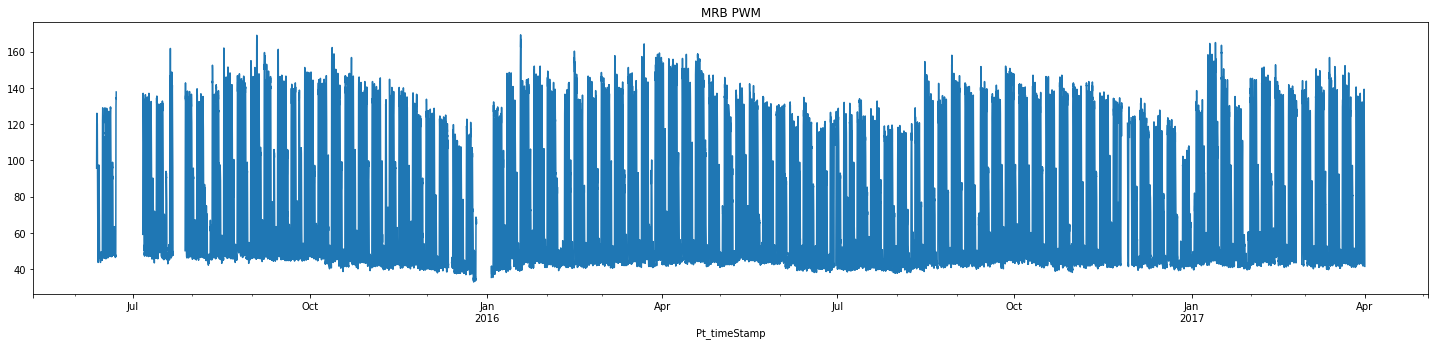

In [6]:
mrb_train_df = mrb_train[0][1]
mrb_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='MRB PWM')

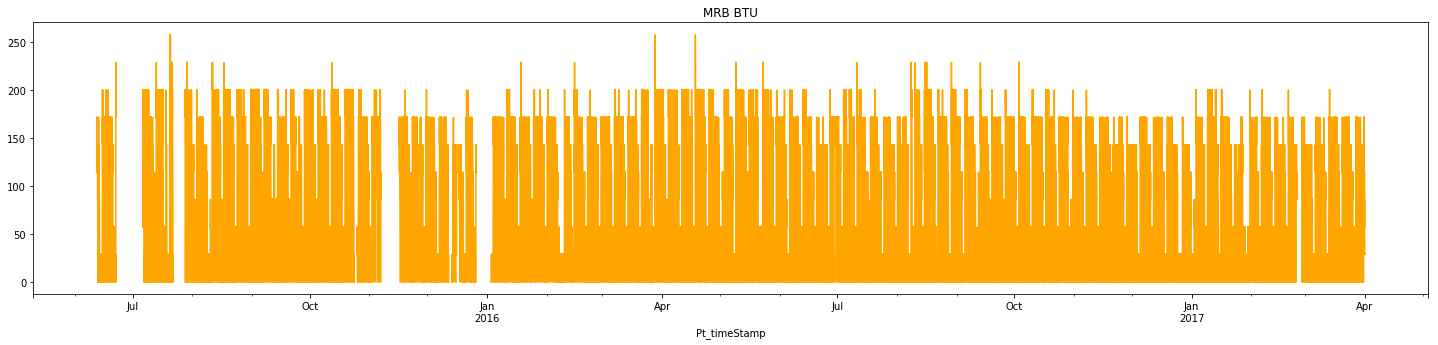

In [7]:
mrb_train_df['BTU_30min_avg'].plot(figsize=(25, 5), title='MRB BTU', color='orange')

## Split a validation set out from the train set

In [8]:
mrb_train_split_df = mrb_train_df[:20000]
mrb_val_split_df = mrb_train_df[20000:]

In [9]:
print('train split = %s\nvalidation split = %s' % (mrb_train_split_df.shape, mrb_val_split_df.shape))

train split = (20000, 10)
validation split = (11617, 10)


## Transform the training data

* Normalise the data - convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [10]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [11]:
mrb_train_data = my_pipeline.fit_transform(mrb_train_split_df)
mrb_train_data

array([[0.46055046, 0.66601942],
       [0.55412844, 0.66699029],
       [0.60366972, 0.66601942],
       ...,
       [0.16880734, 0.11067961],
       [0.07889908, 0.11067961],
       [0.07155963, 0.        ]])

In [12]:
mrb_train_data.shape

(20000, 2)

Text(0.5, 1.0, 'Normalised PWM Training Data')

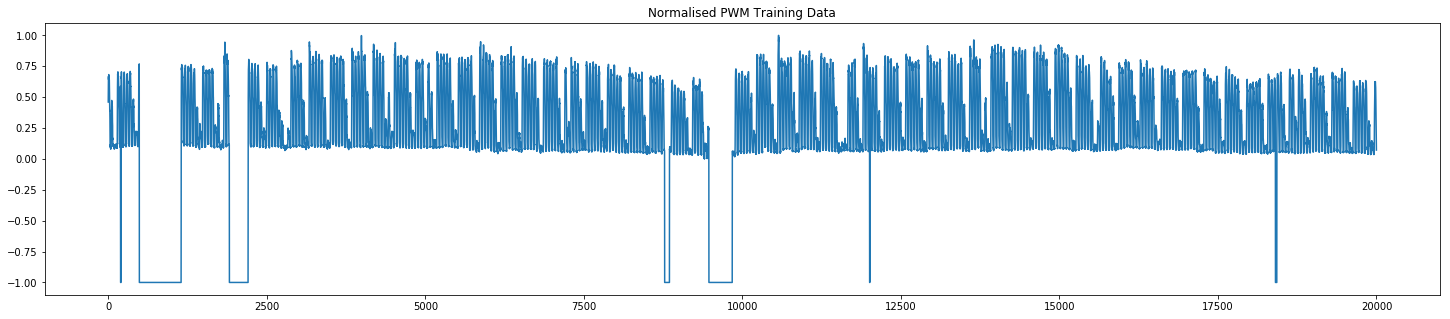

In [13]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

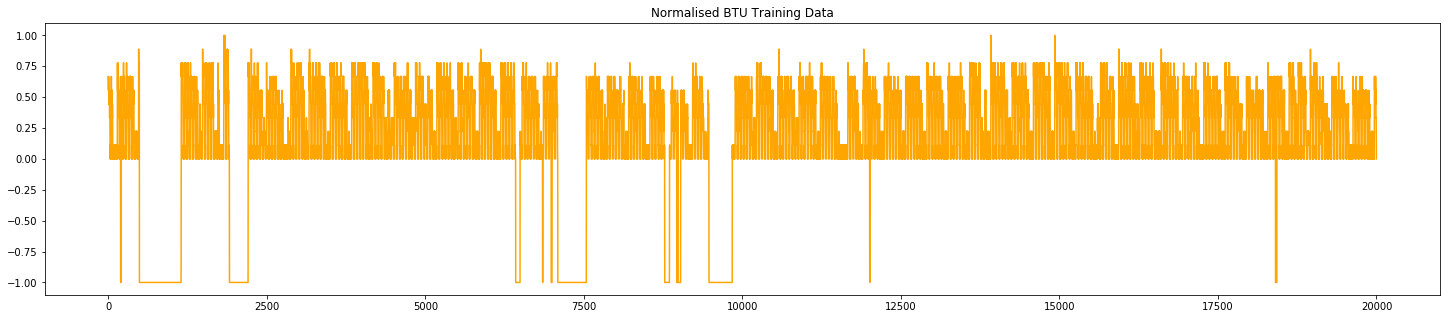

In [14]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

In [15]:
mrb_val_data = my_pipeline.transform(mrb_val_split_df)
mrb_val_data

array([[0.05321101, 0.        ],
       [0.07155963, 0.11067961],
       [0.05688073, 0.        ],
       ...,
       [0.13211009, 0.11067961],
       [0.10825688, 0.11426533],
       [0.06314127, 0.11424788]])

In [16]:
mrb_val_data.shape

(11617, 2)

Text(0.5, 1.0, 'Normalised PWM Validation Data')

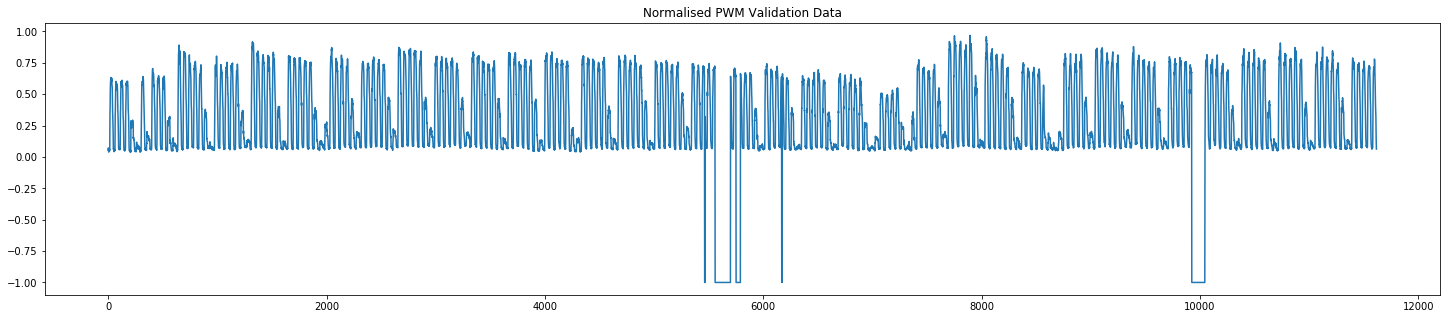

In [17]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_val_data.shape[0]), mrb_val_data[:, 0])
plt.title('Normalised PWM Validation Data')

Text(0.5, 1.0, 'Normalised BTU Validation Data')

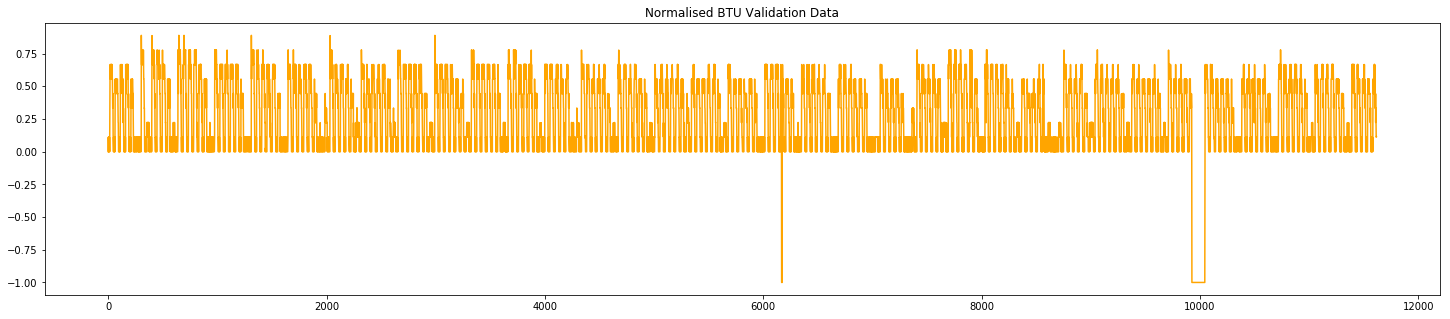

In [18]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_val_data.shape[0]), mrb_val_data[:, 1], color='orange')
plt.title('Normalised BTU Validation Data')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [19]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

In [20]:
# Custom mape metric. Skips all zero values of y-true in computing the mape metric.
import tensorflow as tf
def mape_skip_zeros(y_true, y_pred):
    y_true1 = tf.boolean_mask(y_true, y_true > 0)
    y_pred1 = tf.boolean_mask(y_pred, y_true > 0)
    diff = backend.abs((y_true1 - y_pred1) / y_true1)
    return 100. * backend.mean(diff, axis=-1)

## 4x128 GRU, 2x32 Dense Base Model 

In [ ]:
model = Sequential()
model.add(layers.CuDNNGRU(128, return_sequences=True, input_shape=(None, mrb_train_data.shape[-1])))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=[mape_skip_zeros])

In [21]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


### Train the RNN

In [22]:
callbacks_list = [
    ModelCheckpoint(
        filepath='MRB-base-4x128gru-2x32dense.best-epchxxx.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [23]:
histories = []

In [28]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('final results', 'models', 'MRB-1base-4x128gru-2x32dense-histories-epch250.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('final results', 'models', 'MRB-1base-4x128gru-2x32dense-epch250.h5'),
                  custom_objects={'mape_skip_zeros': mape_skip_zeros})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [35]:
train_to_epoch = 500
start_epoch = 350
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-14 15:01:57.755342

Training Duration = 0:30:52.285593


In [36]:
model.save('MRB-base-4x128gru-2x32dense-epch' + str(train_to_epoch) + '.h5')

In [37]:
with open('MRB-base-4x128gru-2x32dense-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

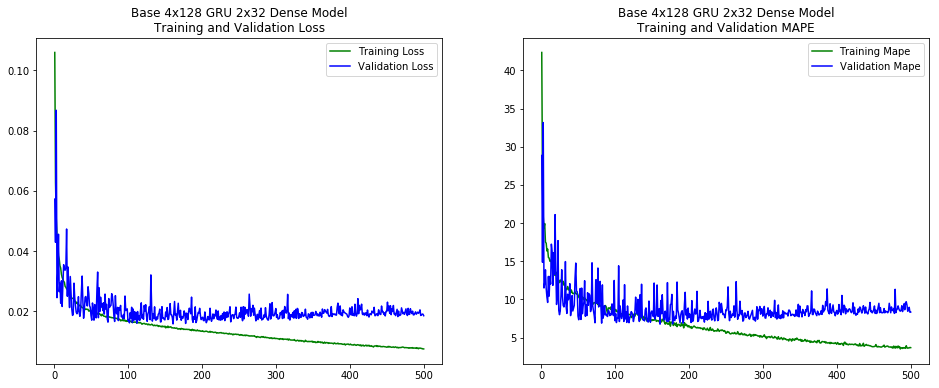

In [38]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mape_skip_zeros']:
        train_mape.append(a_mape)
    for a_mape in h['val_mape_skip_zeros']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 4x128 GRU 2x32 Dense Model\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('Base 4x128 GRU 2x32 Dense Model\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [39]:
print('Min Validation Loss = {} @ epoch {}\nMin Train MAE = {}\nMin Validation MAE = {}'.format(
    min(val_loss),
    val_loss.index(min(val_loss)),
    min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()),
    min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())))

Min Validation Loss = 0.01584383720218335 @ epoch 160
Min Train MAE = 1.0261527355506237
Min Validation MAE = 2.1587228187974814


### Run Results
* Run 1
    * Min Validation Loss = 0.01584383720218335 @ epoch 160
    * Min Train MAE = 1.6631645106412412
    * Min Validation MAE = 2.1587228187974814
* Run 2
    * Min Validation Loss = 0.015915614495288128 @ epoch 151
    * Min Train MAE = 1.5938681888417536
    * Min Validation MAE = 2.1685024749830073
* Run 3
    * Min Validation Loss = 0.015571031362611802 @ epoch 152
    * Min Train MAE = 1.4273410841405039
    * Min Validation MAE = 2.121553023155858

In [ ]:
# Load best model
best_model = load_model(os.path.join('models', 'base3mrb-4x128gru-2x32dense.best-epch176.h5'),
                       custom_objects={'mape_skip_zeros': mape_skip_zeros})
best_model.summary()

In [ ]:
gen_pred = mu.DataGenerator(mrb_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                            batch_size=batch_size, step=step)
mrb_train_preds = best_model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
mrb_train_preds.shape

In [ ]:
mrb_train_preds1 = np.concatenate([mrb_train_preds, np.zeros((mrb_train_preds.shape[0], 1))], axis=1)
mrb_train_preds1.shape

In [ ]:
mrb_train_preds1 = my_pipeline.inverse_transform(mrb_train_preds1)
mrb_train_preds1

In [ ]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if (mrb_train_data[i, 0] > mu.MASK_VALUE) and (np.any(mrb_train_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        mrb_train_preds_withnan[i] = mrb_train_preds1[j, 0]
        j += 1
mrb_train_preds_withnan.shape

In [ ]:
mrb_train_data.shape

In [ ]:
gen_val_pred = mu.DataGenerator(mrb_val_data,
                                lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                                batch_size=batch_size, step=step)
mrb_val_preds = best_model.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)
mrb_val_preds.shape

In [ ]:
mrb_val_preds1 = np.concatenate([mrb_val_preds, np.zeros((mrb_val_preds.shape[0], 1))], axis=1)
mrb_val_preds1 = my_pipeline.inverse_transform(mrb_val_preds1)
mrb_val_preds_withnan = np.full((mrb_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_val_data)):
    if (mrb_val_data[i, 0] > mu.MASK_VALUE) and (np.any(mrb_val_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        mrb_val_preds_withnan[i] = mrb_val_preds1[j, 0]
        j += 1
mrb_val_preds_withnan.shape

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(mrb_train_df['PWM_30min_avg'])
plt.plot(mrb_train_df.index[:20000], mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.plot(mrb_train_df.index[20000:], mrb_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

In [ ]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(mrb_train_df.iloc[1000:1500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1000:1500], mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1240:1300], mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.index[1241:1301], mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(mrb_train_df.iloc[20000:20500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20000:20500], mrb_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.index[20391:20451], mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()

## 4x64 GRU, 1x32 Dense Base Model

In [21]:
model = Sequential()
model.add(layers.CuDNNGRU(64, return_sequences=True, input_shape=(None, mrb_train_data.shape[-1])))
model.add(layers.CuDNNGRU(64, return_sequences=True))
model.add(layers.CuDNNGRU(64, return_sequences=True))
model.add(layers.CuDNNGRU(64))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=[mape_skip_zeros])

In [60]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


In [61]:
histories = []

In [62]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('final results', 'models', 'MRB-2base-4x64gru-1x32dense-histories-epch250.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('final results', 'models', 'MRB-2base-4x64gru-1x32dense-epch250.h5'),
                  custom_objects={'mape_skip_zeros': mape_skip_zeros})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 64)          13056     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 64)          24960     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 64)          24960     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 64)                24960     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 90,049
Trainable params: 90,049
Non-trainable params: 0
_________________________________________________________________


In [63]:
callbacks_list = [
    ModelCheckpoint(
        filepath='MRB-2base-4x64gru-1x32dense.best-epchxxx.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [64]:
train_to_epoch = 500
start_epoch = 250
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-14 17:10:51.822863

Training Duration = 0:27:48.068336


In [65]:
model.save('MRB-2base-4x64gru-1x32dense-epch' + str(train_to_epoch) + '.h5')

In [66]:
with open('MRB-2base-4x64gru-1x32dense-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

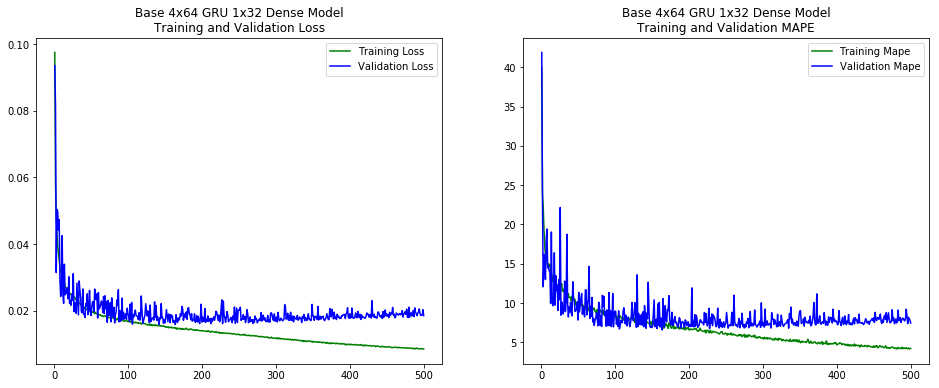

In [67]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mape_skip_zeros']:
        train_mape.append(a_mape)
    for a_mape in h['val_mape_skip_zeros']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 4x64 GRU 1x32 Dense Model\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('Base 4x64 GRU 1x32 Dense Model\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [68]:
print('Min Validation Loss = {} @ epoch {}\nMin Train MAE = {}\nMin Validation MAE = {}'.format(
    min(val_loss),
    val_loss.index(min(val_loss)),
    min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()),
    min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())))

Min Validation Loss = 0.015819116016037693 @ epoch 163
Min Train MAE = 1.1543119820656582
Min Validation MAE = 2.155354557185136


### Run Results
* Run 1
    * Min Validation Loss = 0.016185709941317527 @ epoch 160
    * Min Train MAE = 1.7585835145202942
    * Min Validation MAE = 2.205302979504513
* Run 2
    * Min Validation Loss = 0.015819116016037693 @ epoch 163
    * Min Train MAE = 1.7445003029743082
    * Min Validation MAE = 2.155354557185136
* Run 3
    * Min Validation Loss = 0.015773946761710445 @ epoch 214
    * Min Train MAE = 1.680296722817047
    * Min Validation MAE = 2.149200246283048

In [ ]:
# Load best model
best_model = load_model(os.path.join('models', 'base1mrb-4x128gru-2x32dense-dropout0202.best-epch009.h5'))
best_model.summary()

In [ ]:
gen_pred = mu.DataGenerator(mrb_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                            batch_size=batch_size, step=step)
mrb_train_preds = best_model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
mrb_train_preds.shape

In [ ]:
mrb_train_preds1 = np.concatenate([mrb_train_preds, np.zeros((mrb_train_preds.shape[0], 1))], axis=1)
mrb_train_preds1.shape

In [ ]:
mrb_train_preds1 = my_pipeline.inverse_transform(mrb_train_preds1)
mrb_train_preds1

In [ ]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_train_data)):
    if mrb_train_data[i, 0] > -1:
        mrb_train_preds_withnan[i] = mrb_train_preds1[j, 0]
        j += 1
mrb_train_preds_withnan.shape

In [ ]:
gen_val_pred = mu.DataGenerator(mrb_val_data,
                                lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                                batch_size=batch_size, step=step)
mrb_val_preds = best_model.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)
mrb_val_preds.shape

In [ ]:
mrb_val_preds1 = np.concatenate([mrb_val_preds, np.zeros((mrb_val_preds.shape[0], 1))], axis=1)
mrb_val_preds1 = my_pipeline.inverse_transform(mrb_val_preds1)
mrb_val_preds_withnan = np.full((mrb_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_val_data)):
    if mrb_val_data[i, 0] > -1:
        mrb_val_preds_withnan[i] = mrb_val_preds1[j, 0]
        j += 1
mrb_val_preds_withnan.shape

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(mrb_train_df['PWM_30min_avg'])
plt.plot(mrb_train_df.index[:20000], mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.plot(mrb_train_df.index[20000:], mrb_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

In [ ]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(mrb_train_df.iloc[1000:1500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1000:1500], mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1240:1300], mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.index[1241:1301], mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(mrb_train_df.iloc[20000:20500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20000:20500], mrb_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.index[20391:20451], mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()

## 4x32 GRU Base Model

In [21]:
model = Sequential()
model.add(layers.CuDNNGRU(32, return_sequences=True, input_shape=(None, mrb_train_data.shape[-1])))
model.add(layers.CuDNNGRU(32, return_sequences=True))
model.add(layers.CuDNNGRU(32, return_sequences=True))
model.add(layers.CuDNNGRU(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=[mape_skip_zeros])

In [21]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


In [22]:
histories = []

In [23]:
callbacks_list = [
    ModelCheckpoint(
        filepath='MRB-3base-4x32gru.best-epchxxx.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [24]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('final results', 'models', 'MRB-3base-4x32gru-histories-epch250.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('final results', 'models', 'MRB-3base-4x32gru-epch250.h5'),
                  custom_objects={'mape_skip_zeros': mape_skip_zeros})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 32)          3456      
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 32)          6336      
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 32)          6336      
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 32)                6336      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 22,497
Trainable params: 22,497
Non-trainable params: 0
_________________________________________________________________


In [25]:
train_to_epoch = 600
start_epoch = 250
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-15 12:44:12.035595

Training Duration = 0:32:37.041687


In [26]:
model.save('MRB-3base-4x32gru-epch' + str(train_to_epoch) + '.h5')

In [27]:
with open('MRB-3base-4x32gru-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

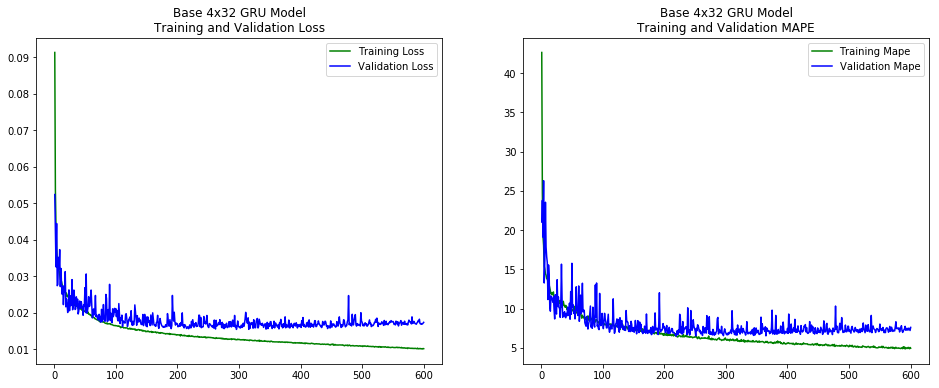

In [28]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mape_skip_zeros']:
        train_mape.append(a_mape)
    for a_mape in h['val_mape_skip_zeros']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 4x32 GRU Model\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('Base 4x32 GRU Model\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [29]:
print('Min Validation Loss = {} @ epoch {}\nMin Train MAE = {}\nMin Validation MAE = {}'.format(
    min(val_loss),
    val_loss.index(min(val_loss)),
    min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()),
    min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())))

Min Validation Loss = 0.015483031076987962 @ epoch 295
Min Train MAE = 1.3799038579207026
Min Validation MAE = 2.1095629842396098


### Run Results
* Run 1
    * Min Validation Loss = 0.015586519974737959 @ epoch 240
    * Min Train MAE = 1.8471554530958343
    * Min Validation MAE = 2.123663346558047
* Run 2
    * Min Validation Loss = 0.015957680264693814 @ epoch 189
    * Min Train MAE = 1.7694835957595278
    * Min Validation MAE = 2.174233936064532
* Run 3
    * Min Validation Loss = 0.015483031076987962 @ epoch 295
    * Min Train MAE = 1.3799038579207026
    * Min Validation MAE = 2.1095629842396098

## 2x32 GRU Base Model

In [21]:
model = Sequential()
model.add(layers.CuDNNGRU(32, return_sequences=True, input_shape=(None, mrb_train_data.shape[-1])))
model.add(layers.CuDNNGRU(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=[mape_skip_zeros])

In [22]:
gen_train = mu.DataGenerator(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(mrb_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 87


In [23]:
histories = []

In [24]:
callbacks_list = [
    ModelCheckpoint(
        filepath='MRB-base-2x32gru.best-epchxxx.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]


In [25]:
train_to_epoch = 800
start_epoch = 0
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-14 13:24:39.699978

Training Duration = 0:35:52.894636


In [26]:
model.save('MRB-base-2x32gru-epch' + str(train_to_epoch) + '.h5')

In [27]:
with open('MRB-base-2x32gru-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

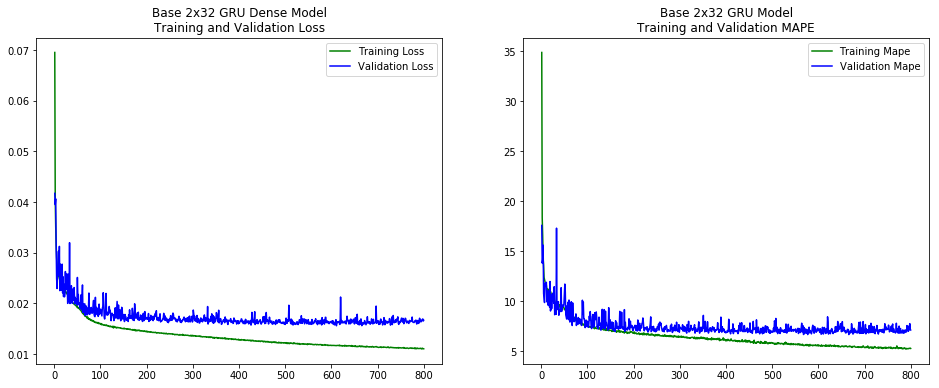

In [28]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mape_skip_zeros']:
        train_mape.append(a_mape)
    for a_mape in h['val_mape_skip_zeros']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 2x32 GRU Dense Model\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('Base 2x32 GRU Model\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [29]:
print('Min Validation Loss = {} @ epoch {}\nMin Train MAE = {}\nMin Validation MAE = {}'.format(
    min(val_loss),
    val_loss.index(min(val_loss)),
    min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()),
    min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())))

Min Validation Loss = 0.015591392283384374 @ epoch 610
Min Train MAE = 1.5006930478192688
Min Validation MAE = 2.124327198611121


### Run Results
* Run 1
    * Min Validation Loss = 0.015413931475718363 @ epoch 532
    * Min Train MAE = 1.5016400295646124
    * Min Validation MAE = 2.100148163566627
* Run 2    
    * Min Validation Loss = 0.015968514665800952 @ epoch 351
    * Min Train MAE = 1.500368114443398
    * Min Validation MAE = 2.1757101232153797
* Run 3
    * Min Validation Loss = 0.015591392283384374 @ epoch 610
    * Min Train MAE = 1.5006930478192688
    * Min Validation MAE = 2.124327198611121

# =========== ALL BELOW TO BE EDITED =================